In [ ]:
# 📦 Temel veri işleme ve analiz kütüphaneleri
import pandas as pd
import numpy as np
import os
from glob import glob
from datetime import datetime

# 🧼 Ön işleme & makine öğrenmesi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# 📊 Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# 🌍 Coğrafi veri desteği
import geopandas as gpd

# 🔕 Uyarı bastırma
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Tüm .csv dosyalarının yollarını listele
csv_files = glob("data/*.csv")


# Dosyaları okuyup birleştir
dataframes = []
for file in csv_files:
    try:
        df = pd.read_csv(file, encoding='utf-8', errors='ignore')
        if 'parameter' in df.columns and df['parameter'].isin(['pm25', 'pm10']).any():
            dataframes.append(df)
    except Exception as e:
        print(f"Hata: {file} dosyası okunamadı → {e}")

# Hepsini tek bir veri çerçevesinde birleştir
data = pd.concat(dataframes, ignore_index=True)
print(f"{len(csv_files)} dosya bulundu. Toplam {data.shape[0]} gözlem yüklendi.")

# İlk birkaç satırı kontrol et
data.head()

60 dosya bulundu.


,location_id,location_name,parameter,value,unit,datetimeUtc,datetimeLocal,timezone,latitude,longitude,country_iso,isMobile,isMonitor,owner_name,provider
0,270734,Trabzon - Uzungöl,no2,12.23,µg/m³,2021-11-23T19:00:00Z,2021-11-23T22:00:00+03:00,Europe/Istanbul,40.622749,40.306088,NaN,NaN,NaN,Unknown Governmental Organization,Türkiye
1,270734,Trabzon - Uzungöl,no2,10.97,µg/m³,2021-11-26T16:00:00Z,2021-11-26T19:00:00+03:00,Europe/Istanbul,40.622749,40.306088,NaN,NaN,NaN,Unknown Governmental Organization,Türkiye
2,270734,Trabzon - Uzungöl,no2,11.10,µg/m³,2021-11-26T17:00:00Z,2021-11-26T20:00:00+03:00,Europe/Istanbul,40.622749,40.306088,NaN,NaN,NaN,Unknown Governmental Organization,Türkiye
3,270734,Trabzon - Uzungöl,no2,11.33,µg/m³,2021-11-26T18:00:00Z,2021-11-26T21:00:00+03:00,Europe/Istanbul,40.622749,40.306088,NaN,NaN,NaN,Unknown Governmental Organization,Türkiye
4,270734,Trabzon - Uzungöl,no2,14.56,µg/m³,2021-11-26T19:00:00Z,2021-11-26T22:00:00+03:00,Europe/Istanbul,40.622749,40.306088,NaN,NaN,NaN,Unknown Governmental Organization,Türkiye


In [4]:
data.shape, data.columns, data.dtypes

((249436, 15),
 Index(['location_id', 'location_name', 'parameter', 'value', 'unit',
        'datetimeUtc', 'datetimeLocal', 'timezone', 'latitude', 'longitude',
        'country_iso', 'isMobile', 'isMonitor', 'owner_name', 'provider'],
       dtype='object'),
 location_id        int64
 location_name     object
 parameter         object
 value            float64
 unit              object
 datetimeUtc       object
 datetimeLocal     object
 timezone          object
 latitude         float64
 longitude        float64
 country_iso      float64
 isMobile         float64
 isMonitor        float64
 owner_name        object
 provider          object
 dtype: object)

In [5]:
# İstenilen sütunlar
columns_needed = [
    'location_id', 'location_name', 'parameter', 'value',
    'datetimeLocal', 'latitude', 'longitude'
]

# Eğer 'unit' sütunu varsa ekle
if 'unit' in data.columns:
    columns_needed.append('unit')

# Var olan sütunlara göre filtrele
data = data[columns_needed]

# Tarih formatını dönüştür
data['datetimeLocal'] = pd.to_datetime(data['datetimeLocal'])

# Gruplama ve saatlik ortalama
data = data.groupby([
    'location_id', 'location_name', 'parameter',
    'latitude', 'longitude', pd.Grouper(key='datetimeLocal', freq='1H')
])['value'].mean().reset_index()

data.head(), data.shape, data.dtypes

(   location_id            location_name parameter   latitude  longitude  \
 0         3548  Giresun - Gemilercekeği        co  40.914445  38.398564   
 1         3548  Giresun - Gemilercekeği        co  40.914445  38.398564   
 2         3548  Giresun - Gemilercekeği        co  40.914445  38.398564   
 3         3548  Giresun - Gemilercekeği        co  40.914445  38.398564   
 4         3548  Giresun - Gemilercekeği        co  40.914445  38.398564   
 
               datetimeLocal   value  
 0 2016-12-23 03:00:00+03:00  1309.0  
 1 2016-12-23 04:00:00+03:00  1011.0  
 2 2016-12-23 05:00:00+03:00  1072.0  
 3 2016-12-23 06:00:00+03:00   766.0  
 4 2016-12-23 07:00:00+03:00  1071.0  ,
 (243436, 7),
 location_id                          int64
 location_name                       object
 parameter                           object
 latitude                           float64
 longitude                          float64
 datetimeLocal    datetime64[ns, UTC+03:00]
 value                       

In [6]:
# PM2.5 ve PM10 için WHO'ya göre eşik değerler
pm25_limit = 35  # 24 saatlik risk eşiği
pm10_limit = 100  # 24 saatlik risk eşiği

# Mevcut pivotlu veriyi oluşturalım
data_pm25 = data[data["parameter"] == "pm25"].rename(columns={"value": "PM25"})
data_pm10 = data[data["parameter"] == "pm10"].rename(columns={"value": "PM10"})

# İkisini birleştir (outer join ile hem PM10 hem PM25'i içeren tüm kayıtları al)
merged = pd.merge(
    data_pm25,
    data_pm10,
    on=["location_id", "location_name", "latitude", "longitude", "datetimeLocal"],
    how="outer"
)

# PM25 ve PM10 skalalarını hesapla (eksikse boş bırak)
merged["PM25_skali"] = np.clip(merged["PM25"] / pm25_limit, 0, 1)
merged["PM10_skali"] = np.clip(merged["PM10"] / pm10_limit, 0, 1)

# Astım riski: PM25 varsa ağırlıklı, yoksa sadece PM10 ile
merged["astim_risk_skoru"] = np.where(
    merged["PM25"].isna(),
    merged["PM10_skali"] * 0.3,
    0.7 * merged["PM25_skali"] + 0.3 * merged["PM10_skali"]
)

# Temiz veri seti
veri = merged[[
    "location_id", "location_name", "latitude", "longitude", "datetimeLocal",
    "PM25", "PM10", "astim_risk_skoru"
]]

veri.head(), data['parameter'].value_counts()


(   location_id            location_name   latitude  longitude  \
 0         3548  Giresun - Gemilercekeği  40.914445  38.398564   
 1         3548  Giresun - Gemilercekeği  40.914445  38.398564   
 2         3548  Giresun - Gemilercekeği  40.914445  38.398564   
 3         3548  Giresun - Gemilercekeği  40.914445  38.398564   
 4         3548  Giresun - Gemilercekeği  40.914445  38.398564   
 
               datetimeLocal  PM25  PM10  astim_risk_skoru  
 0 2016-12-23 03:00:00+03:00   NaN  47.0             0.141  
 1 2016-12-23 04:00:00+03:00   NaN  35.0             0.105  
 2 2016-12-23 05:00:00+03:00   NaN  25.0             0.075  
 3 2016-12-23 06:00:00+03:00   NaN  14.0             0.042  
 4 2016-12-23 07:00:00+03:00   NaN   9.0             0.027  ,
 parameter
 pm10    57828
 no2     50829
 so2     50565
 co      29339
 o3      27828
 pm25    27047
 Name: count, dtype: int64)

In [7]:
# astim_risk_skoru içi boş (NaN) olanları at
veri = veri.dropna(subset=["astim_risk_skoru"])

In [8]:
print(veri.shape)
print(veri.dtypes)
print(veri.isnull().sum())

(57828, 8)
location_id                             int64
location_name                          object
latitude                              float64
longitude                             float64
datetimeLocal       datetime64[ns, UTC+03:00]
PM25                                  float64
PM10                                  float64
astim_risk_skoru                      float64
dtype: object
location_id             0
location_name           0
latitude                0
longitude               0
datetimeLocal           0
PM25                46017
PM10                    0
astim_risk_skoru        0
dtype: int64


In [9]:
# Özellikler ve hedef
X = veri[["PM25", "PM10"]]
y = veri["astim_risk_skoru"]

# Eksik değerleri ortalama ile dolduralım
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Özellikleri ölçekleyelim
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Eğitim-test ayırımı
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [10]:
# Kullanılacak modeller
modeller = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}


In [11]:
# Sonuçları sakla
sonuclar = []

for isim, model in modeller.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    sonuclar.append({
        "Model": isim,
        "MAE": mae,
        "RMSE": rmse,
        "R2 Score": r2
    })

# Sonuçları DataFrame olarak göster
sonuc_df = pd.DataFrame(sonuclar).sort_values("R2 Score", ascending=False)
sonuc_df.reset_index(drop=True, inplace=True)
sonuc_df


,Model,MAE,RMSE,R2 Score
0,Decision Tree,0.000430,0.001676,0.999952
1,Random Forest,0.000244,0.002745,0.999871
2,Gradient Boosting,0.003059,0.005492,0.999483
3,K-Nearest Neighbors,0.007348,0.022876,0.991032
4,Support Vector,0.087169,0.117725,0.762497
5,Ridge Regression,0.172230,0.219608,0.173532
6,Linear Regression,0.172230,0.219608,0.173532
7,Lasso Regression,0.174212,0.241568,-0.000026


In [12]:
# En iyi modeli seç (örneğin en yüksek R2 Score'a sahip)
en_iyi_model_adi = sonuc_df.iloc[0]["Model"]
en_iyi_model = modeller[en_iyi_model_adi]

print(f"En iyi model: {en_iyi_model_adi}")

# Özellik önemlerini çıkar (ağaç temelli modellerde)
if hasattr(en_iyi_model, "feature_importances_"):
    for name, score in zip(["PM25", "PM10"], en_iyi_model.feature_importances_):
        print(f"{name}: {score:.4f}")


En iyi model: Decision Tree
PM25: 0.8623
PM10: 0.1377


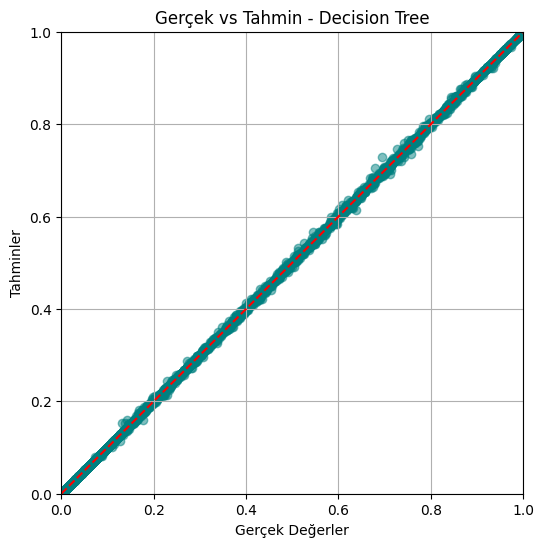

In [13]:
# Test kümesinde tahmin
y_pred = en_iyi_model.predict(X_test)

# Gerçek vs Tahmin grafiği
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([0,1], [0,1], 'r--')  # ideal doğru: y = x
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahminler")
plt.title(f"Gerçek vs Tahmin - {en_iyi_model_adi}")
plt.grid(True)
plt.axis("square")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()


In [14]:
scores = cross_val_score(en_iyi_model, X_scaled, y, cv=5, scoring='r2')
print(f"5-Fold R2 Scores: {scores}")
print(f"Ortalama R2: {scores.mean():.5f}")


5-Fold R2 Scores: [1.         0.99999998 1.         0.99874273 0.99960796]
Ortalama R2: 0.99967


In [32]:
# Eğitim verisinde kullanılan scaler ve imputer ile tüm veri için hazırlık
X_full = veri[["PM25", "PM10"]]
X_full_imputed = imputer.transform(X_full)
X_full_scaled = scaler.transform(X_full_imputed)

# Tahmin üret
veri["tahmin_edilen_risk"] = en_iyi_model.predict(X_full_scaled)

# Sonuçları kontrol et
veri[["PM25", "PM10", "astim_risk_skoru", "tahmin_edilen_risk"]].head()


,PM25,PM10,astim_risk_skoru,tahmin_edilen_risk
0,NaN,47.0,0.141,0.141
1,NaN,35.0,0.105,0.105
2,NaN,25.0,0.075,0.075
3,NaN,14.0,0.042,0.042
4,NaN,9.0,0.027,0.027


In [16]:
# Sadece risk skoru hesaplanabilen (NaN olmayan) verileri al
veri_heatmap = veri.dropna(subset=["astim_risk_skoru"])

In [17]:
# HeatMap için format: [latitude, longitude, ağırlık (risk skoru)]
heatmap_data = veri_heatmap[["latitude", "longitude", "astim_risk_skoru"]].values.tolist()

In [18]:
import folium
from folium.plugins import HeatMap

# Harita oluştur (yaklaşık Türkiye ortası)
harita = folium.Map(location=[39.0, 35.0], zoom_start=6, tiles="CartoDB positron")

# Isı haritasını ekle
HeatMap(
    heatmap_data,
    min_opacity=0.2,
    radius=12,
    blur=15,
    max_zoom=1
).add_to(harita)

# Göster
harita

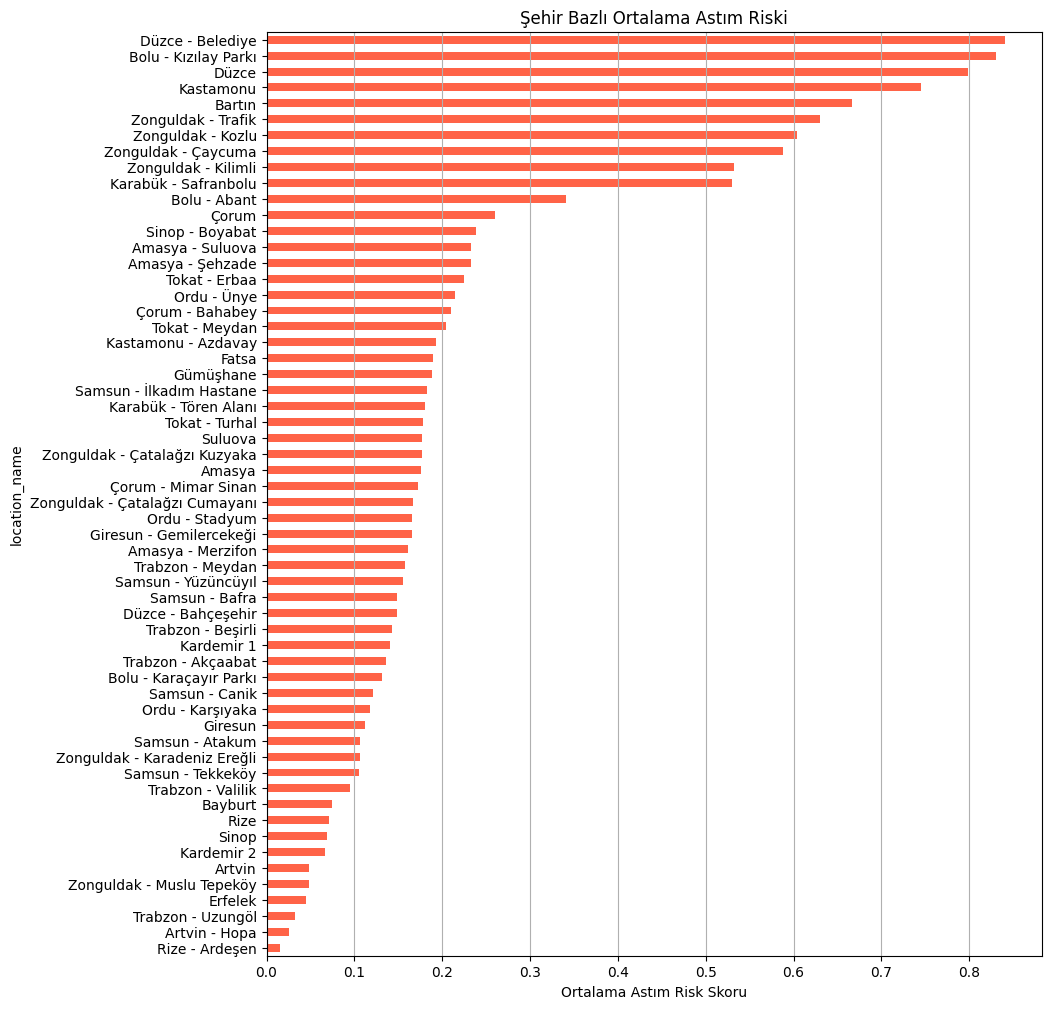

In [19]:
import matplotlib.pyplot as plt

# Şehir bazlı ortalama risk
sehir_risk = veri_heatmap.groupby("location_name")["astim_risk_skoru"].mean().sort_values()

plt.figure(figsize=(10, 12))
sehir_risk.plot(kind="barh", color="tomato")
plt.xlabel("Ortalama Astım Risk Skoru")
plt.title("Şehir Bazlı Ortalama Astım Riski")
plt.grid(True, axis='x')
plt.show()


In [22]:
# Şehir ve parametre bazında veri sayısı
sehir_parametre_sayisi = data[data["parameter"].isin(["pm25", "pm10"])].groupby(
    ["location_name", "parameter"]
)["value"].count().unstack(fill_value=0)

sehir_parametre_sayisi = sehir_parametre_sayisi.rename(columns={"pm25": "PM2.5 Sayısı", "pm10": "PM10 Sayısı"})
sehir_parametre_sayisi


parameter,PM10 Sayısı,PM2.5 Sayısı
location_name,,
Amasya,1000,0
Amasya - Merzifon,1000,0
Amasya - Suluova,1000,0
Amasya - Şehzade,1000,1000
Artvin,1000,0
Artvin - Hopa,1000,41
Bartın,1000,1000
Bayburt,1000,0
Bolu - Abant,1000,1000


In [23]:
# Şehir adını ayırmak için '-' işaretinden böl
data["sehir"] = data["location_name"].str.split("-").str[0].str.strip()

# Şehir ve parametre bazlı sayım
sehir_parametre_sayisi = data[data["parameter"].isin(["pm25", "pm10"])].groupby(
    ["sehir", "parameter"]
)["value"].count().unstack(fill_value=0)

# Kolon adlarını düzenle
sehir_parametre_sayisi = sehir_parametre_sayisi.rename(columns={"pm25": "PM2.5 Sayısı", "pm10": "PM10 Sayısı"})

<Figure size 1200x1000 with 0 Axes>

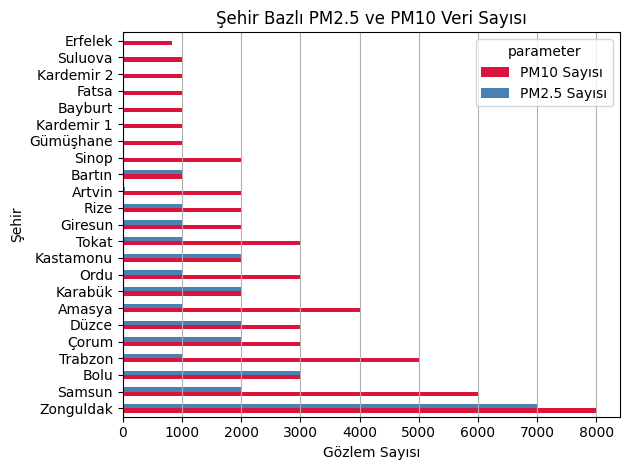

In [24]:
# Toplam sayıya göre sırala
toplam = sehir_parametre_sayisi.sum(axis=1).sort_values(ascending=False)
sirali = sehir_parametre_sayisi.loc[toplam.index]

# Grafik
plt.figure(figsize=(12, 10))
sirali.plot(kind="barh", stacked=False, color=["crimson", "steelblue"])
plt.title("Şehir Bazlı PM2.5 ve PM10 Veri Sayısı")
plt.xlabel("Gözlem Sayısı")
plt.ylabel("Şehir")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()
